## 고급과정 평가
## 날짜 :
## 이름 :
## 사번 :

FashinMNIST를 이용한 이미지 분류

In [159]:
# 필요한 라이브러리 import

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import os
from torch import nn

import torchvision.models as models
import torch
import numpy as np
import random



In [2]:
# random seed를 고정하여 학습 결과가 재현성 있도록 만드세요
# 알고 계신 random seed는 다 고정하세요

In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [4]:
# 데이터셋 불러오기 train데이터와 test 데이터
# 전처리는 텐서화와 정규화(평균 0.1307, 표준편차 0.3081) 진행
# 학습과정에서는 randomrotation 및 randomgorizontalflip 추가
# 데이터셋은 0~3 번 class만 사용할 예정임니다 필요없는 데이터는 삭제하세요.

In [5]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomRotation(10),  # +/- 10도로 회전
     transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 수평 반전
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

target_idx = train_data.targets < 4
train_data.data = train_data.data[target_idx]
train_data.targets = train_data.targets[target_idx]
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])
)
target_idx = test_data.targets < 4
test_data.data = test_data.data[target_idx]
test_data.targets = test_data.targets[target_idx]

In [6]:
# 데이터셋을 순회하고 시각화하기
# 아래와 같은 label map 변수를 선언하고
# 데이터셋을 4x4 subplot을 생성하여 label, image를 random하게 16개 시각화 해보세요

# 0 : "T-Shirt",
# 1: "Trouser",
# 2: "Pullover",
# 3: "Dress",

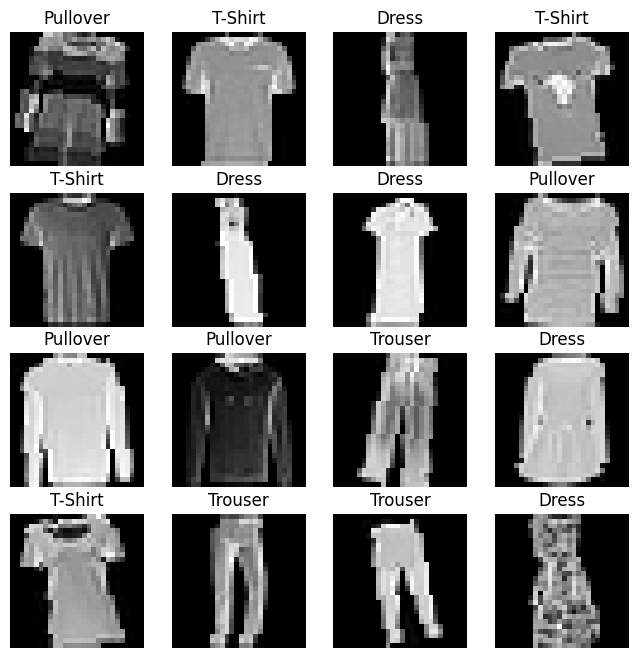

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",

}

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_data), size=(1,)).item()
  img, label = train_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
# DataLoader로 학습용 데이터 준비하기
# Shuffle은 True로하고 Batch size는 32 생성

In [9]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [10]:
# DataLoader를 통해 순회하기(iterate)
# 이미지와 정답(label)을 표시합니다.

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


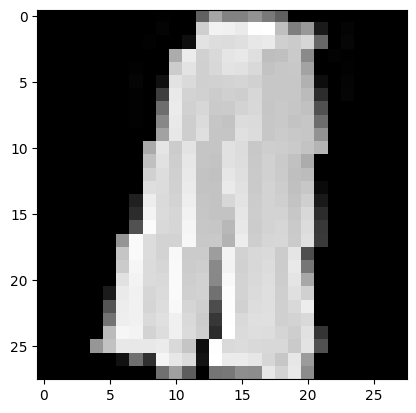

Label: 1(Trouser)


In [11]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}({labels_map[label.item()]})")

In [12]:
# 신경망 모델 구성하기 - 클래스 정의하기
# feature extractor를 sequential을 이용해 만드세요.
# 구성 layer는 아래와 같습니다.
# 1차 conv net : conv2d, relu, maxpool2d, dropout layer 순
# cov2d 커널 사이즈 = 5, maxpool 커널 사이즈 = 2, dropout rate =0.25
# 2차 convnet : conv2d, relu, maxpool2d, dropout layer 순
# cov2d 커널 사이즈 = 3, maxpool 커널 사이즈 = 3, dropout rate =0.25

# linear함수를 이용하여 sequential을 이용하여 Classifier를 만드세요.
# flatten, linear, relu, dropout layer, linear layer를 순차적으로 쌓으세요
# dropout rate = 0.2
# 이를 통합하여 모델 네트워크를 구성하세요.

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.feature_exractor = nn.Sequential(
            # 첫번째 Convolutional Layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            # 두번째 Convolutional Layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout(0.25))
        
        self.classfier = nn.Sequential(
            # Fully Connected Layer에 주입하기 위해 Flatten
            nn.Flatten(),

            # Fully Connected Layer
            nn.Linear(in_features=288, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.2),

            # 출력 레이어)
            nn.Linear(in_features=256, out_features=4)
        )

    def forward(self, x):
        x = self.feature_exractor(x)
        x = self.classfier(x)
        return x


In [14]:
# 신경망 모델 인스턴스 생성 후 구조 출력

In [15]:
model = CNN()
print(model)

CNN(
  (feature_exractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (classfier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [16]:
# loss function, optimizer 정의

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [18]:
# 최적화 코드를 반복하여 수행하는 train_loop 생성
# train 과정에서 loss값이 떨어지는것을 확인 할 수 있도록 epoch에 따라 loss값을 저장하세요.
# train이 끝나면 loss값을 epoch에 따라 matplotlib으로 그려보세요.

Epoch 1
-----------------------------
loss: 1.361241 [   32/24000]
loss: 1.414914 [ 3232/24000]
loss: 1.368124 [ 6432/24000]
loss: 1.349270 [ 9632/24000]
loss: 1.381678 [12832/24000]
loss: 1.331123 [16032/24000]
loss: 1.281452 [19232/24000]
loss: 1.289354 [22432/24000]
Epoch 2
-----------------------------
loss: 1.282860 [   32/24000]
loss: 1.284027 [ 3232/24000]
loss: 1.246542 [ 6432/24000]
loss: 1.224138 [ 9632/24000]
loss: 1.180094 [12832/24000]
loss: 1.177622 [16032/24000]
loss: 1.072866 [19232/24000]
loss: 1.100023 [22432/24000]
Epoch 3
-----------------------------
loss: 1.079900 [   32/24000]
loss: 1.045868 [ 3232/24000]
loss: 0.955990 [ 6432/24000]
loss: 0.979411 [ 9632/24000]
loss: 0.857536 [12832/24000]
loss: 0.768394 [16032/24000]
loss: 0.830978 [19232/24000]
loss: 0.824927 [22432/24000]


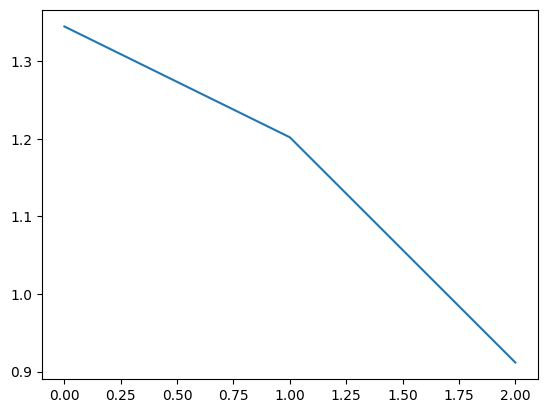

Done!


In [19]:
epochs = 3
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------")
    size = len(train_dataloader.dataset)
    running_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        # prediction, loss 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    # 평균 loss 계산
    avg_loss = running_loss / len(train_dataloader)
    losses.append(avg_loss)
    
plt.plot(losses)
plt.show()
print("Done!")

In [20]:
# 테스트 데이터로 모델의 성능을 측정하는 test_loop 함수 정의
# 테스트 결과를  accuracy, f1, recall, precision의 성능 지표로 산출하세요

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
correct = 0
total = 0
all_prediction = []
gt = []
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, correct = 0, 0

with torch.no_grad():
    for X, y in test_dataloader:
      pred = model(X)
      _, predicted = torch.max(pred.data, 1)
      gt.append(y) 
      all_prediction.append(predicted) 

all_prediction = torch.cat(all_prediction, dim=0).numpy()
gt = torch.cat(gt, dim=0).numpy()

accuracy = accuracy_score(gt, all_prediction)
recall = recall_score(gt, all_prediction, average='macro')
precision = precision_score(gt, all_prediction, average='macro')
f1 = f1_score(gt, all_prediction, average='macro')

print("Done!")

print(f"accuracy : {accuracy:.2f}")
print(f"f1_score : {recall:.2f}")
print(f"recall : {precision:.2f}")
print(f"precision : {f1:.2f}")

Done!
accuracy : 0.75
f1_score : 0.75
recall : 0.75
precision : 0.75


In [22]:
# 모델 저장

In [23]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved")

Model saved


In [24]:
# 저장된 모델 불러오기

# 참고
# 추론(inference)을 하기 전에 model.eval() 메소드를 호출하여
# 드롭아웃(dropout)과 배치 정규화(batch normalization)를 평가 모드(evaluation mode)로 설정해야 합니다.
# 그렇지 않으면 일관성 없는 추론 결과가 생성됩니다.

In [25]:
model_1 = CNN()
model_1.load_state_dict(torch.load('model.pth'))
model_1.eval()
print("Model loaded")

Model loaded


In [26]:
# sample test image 예측 및 시각화
# 8x4 data를 test하고 시각화하여 정답을 맞췄는지 표기하세요.

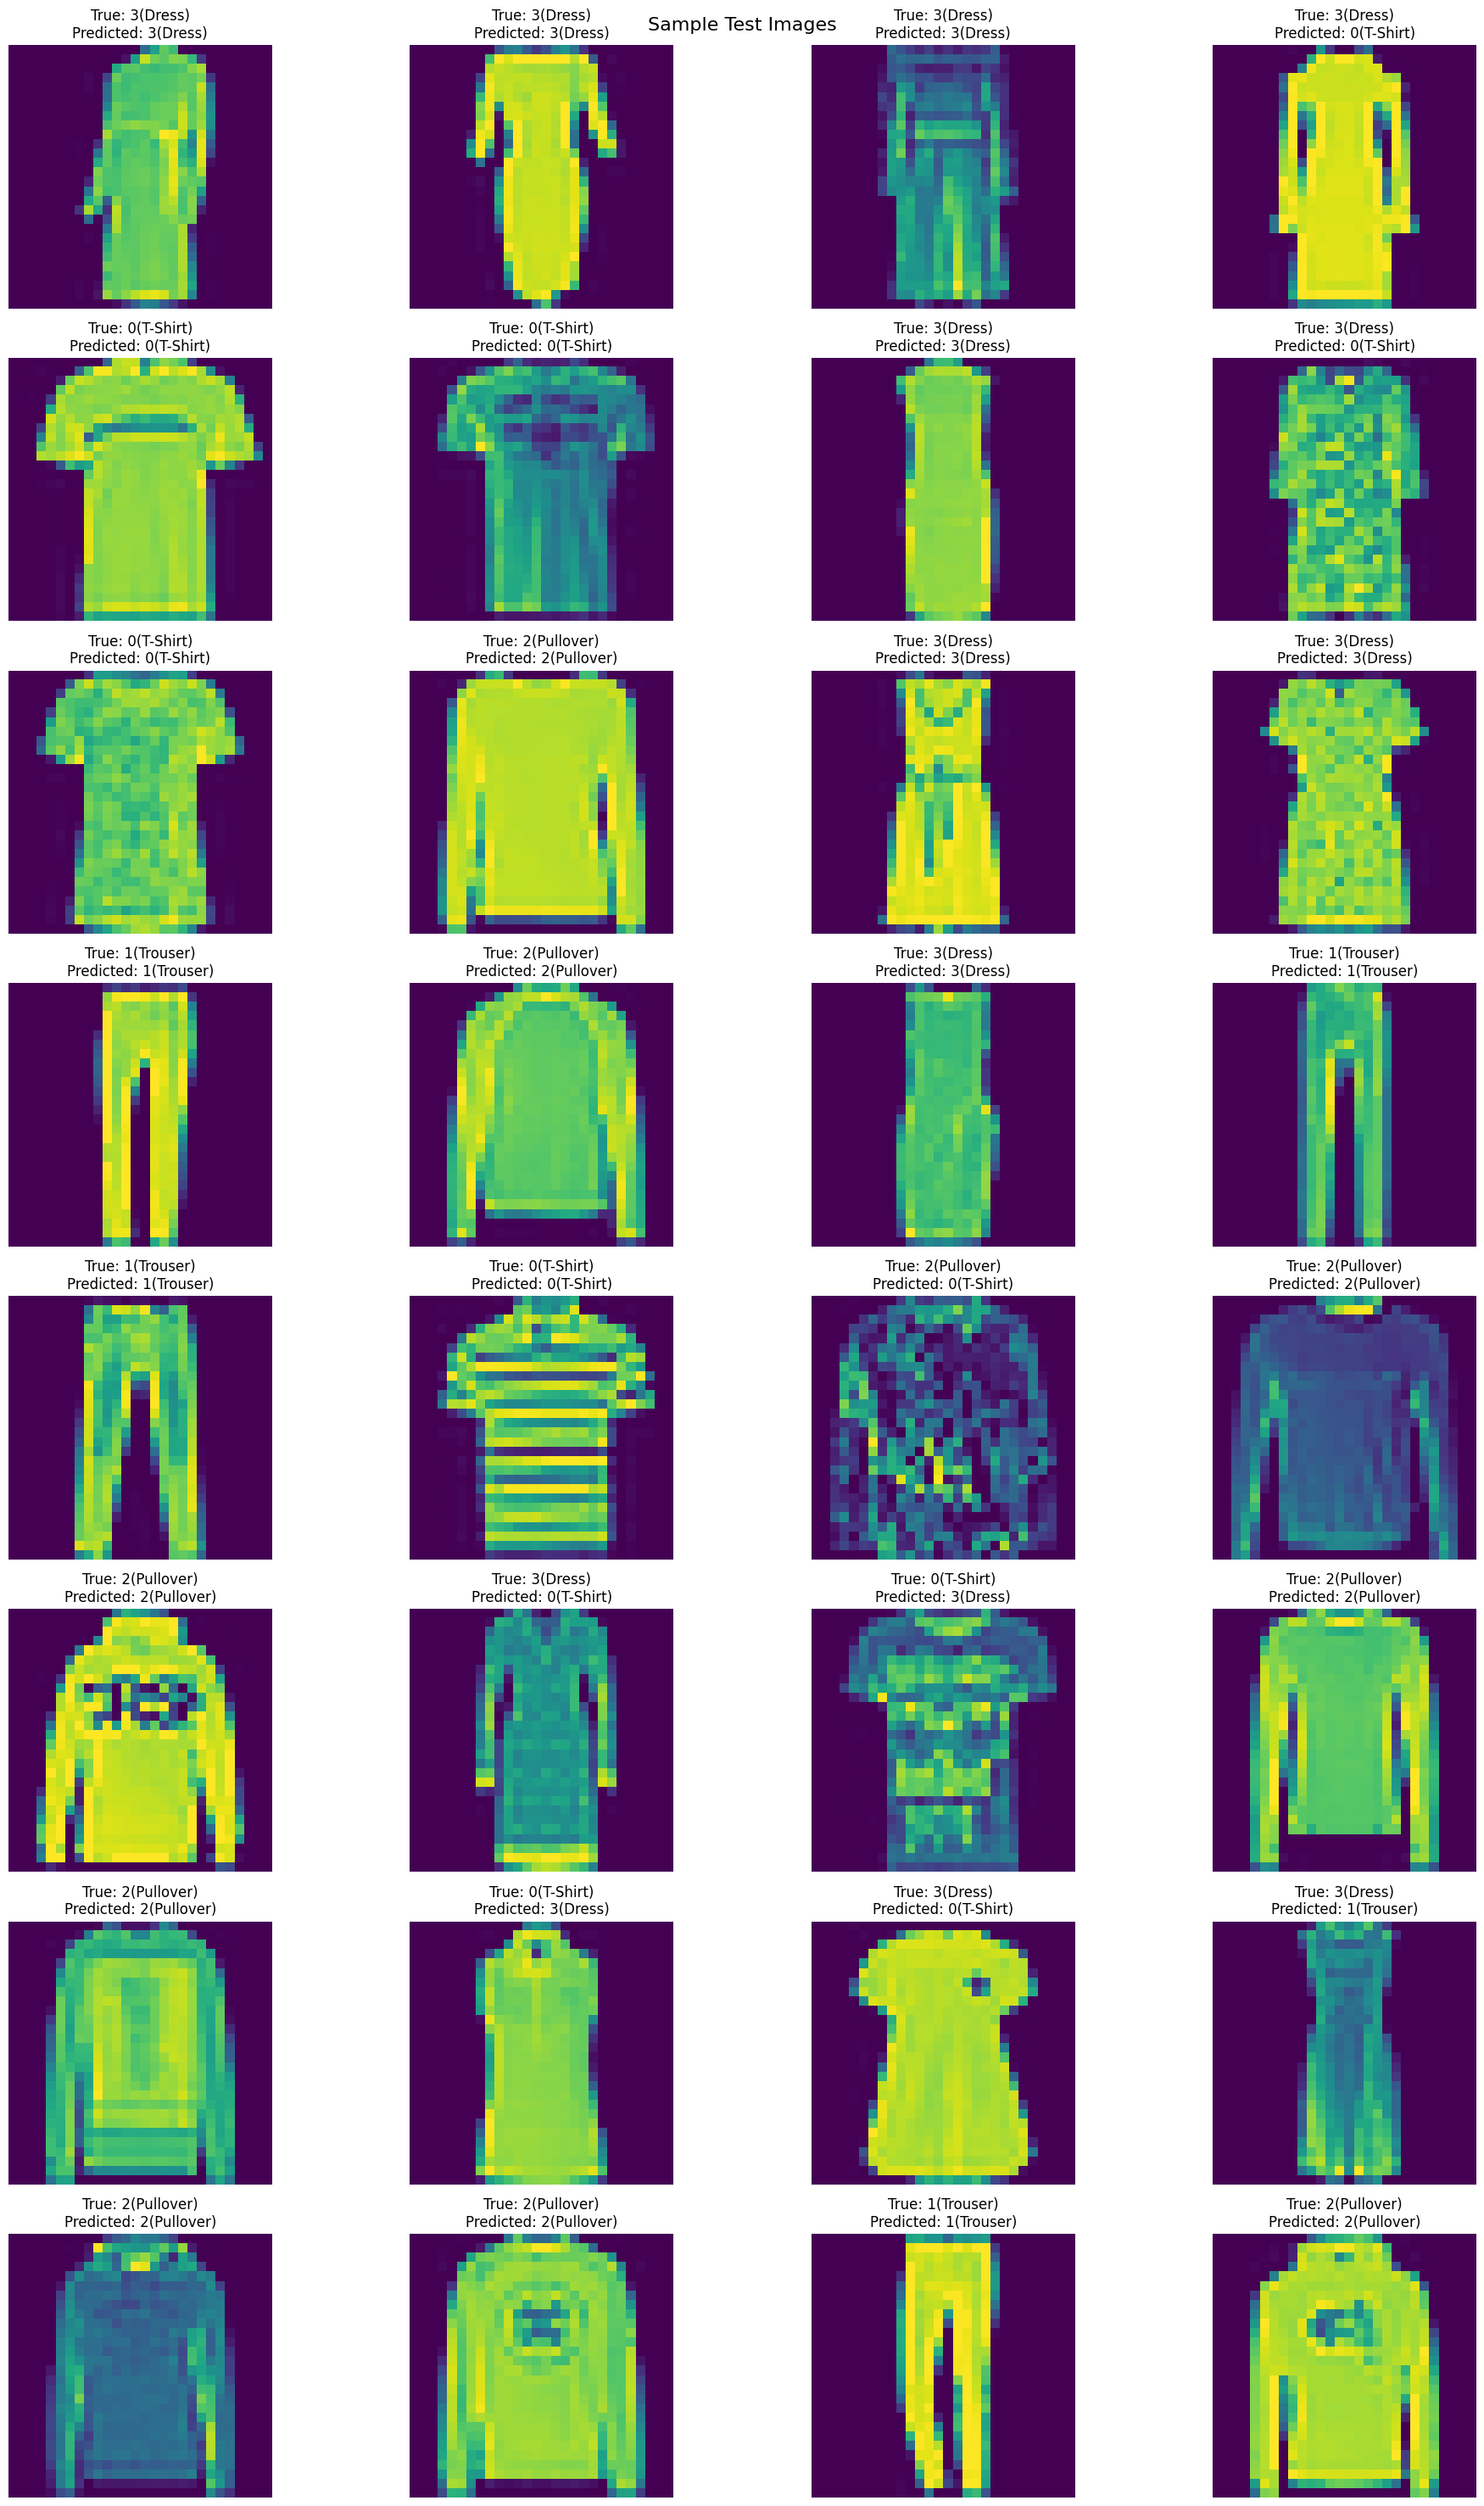

In [27]:
sample_images, sample_labels = next(iter(test_dataloader))

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 30))
fig.suptitle("Sample Test Images", fontsize=16)

with torch.no_grad():
  outputs = model_1(sample_images)
  _, predicted = torch.max(outputs.data, 1)

  for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_images[i].squeeze())
    ax.set_title(f"True: {sample_labels[i]}({labels_map[sample_labels[i].item()]})\nPredicted: {predicted[i].item()}({labels_map[predicted[i].item()]})")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [28]:
# 이미 학습된 모델을 전체 데이터셋에(모든 class사용) 적용한다고 가정하겠습니다.
# 학습된 모델에서 layer 중 classfier를 freeze하여
# 향후 업데이트되지 않도록 설정하고 모델 network를 layer별로 freeze가 잘되었는지 print하세요.

In [32]:
num_ftrs = model.classfier[-1].in_features
model.classfier[-1] = nn.Linear(num_ftrs, 10)
print(model.classfier[-1])


for param in model.parameters():
    param.requires_grad = False

for param in model.classfier.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

Linear(in_features=256, out_features=10, bias=True)
feature_exractor.0.weight: requires_grad=False
feature_exractor.0.bias: requires_grad=False
feature_exractor.4.weight: requires_grad=False
feature_exractor.4.bias: requires_grad=False
classfier.1.weight: requires_grad=True
classfier.1.bias: requires_grad=True
classfier.4.weight: requires_grad=True
classfier.4.bias: requires_grad=True


In [33]:
# 전체 데이터셋을 dataloader에 업로드하고
# freeze모델을 이용하여 finetuning 하세요.
# epoch = 3, learning rate = 0.0001

Epoch 1
-----------------------------
loss: 2.245376 [   32/60000]
loss: 2.314147 [ 3232/60000]
loss: 2.305161 [ 6432/60000]
loss: 2.244895 [ 9632/60000]
loss: 2.254841 [12832/60000]
loss: 2.147105 [16032/60000]
loss: 2.304339 [19232/60000]
loss: 2.190990 [22432/60000]
loss: 2.227311 [25632/60000]
loss: 2.206069 [28832/60000]
loss: 2.168392 [32032/60000]
loss: 2.158710 [35232/60000]
loss: 2.027380 [38432/60000]
loss: 2.058013 [41632/60000]
loss: 2.150999 [44832/60000]
loss: 2.030027 [48032/60000]
loss: 2.019446 [51232/60000]
loss: 1.955509 [54432/60000]
loss: 1.938110 [57632/60000]
Epoch 2
-----------------------------
loss: 1.970613 [   32/60000]
loss: 1.885398 [ 3232/60000]
loss: 1.944699 [ 6432/60000]
loss: 1.987574 [ 9632/60000]
loss: 2.034617 [12832/60000]
loss: 1.889653 [16032/60000]
loss: 1.950902 [19232/60000]
loss: 1.922636 [22432/60000]
loss: 1.931038 [25632/60000]
loss: 1.844082 [28832/60000]
loss: 1.796908 [32032/60000]
loss: 1.874589 [35232/60000]
loss: 1.854983 [38432/600

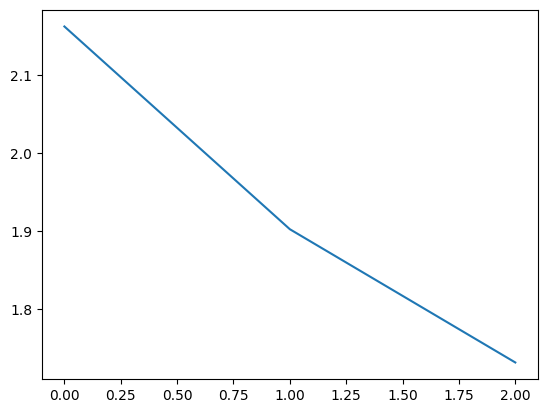

Done!


In [34]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomRotation(10),  # +/- 10도로 회전
     transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 수평 반전
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])
)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

epochs = 3
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------")
    size = len(train_dataloader.dataset)
    running_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        # prediction, loss 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    # 평균 loss 계산
    avg_loss = running_loss / len(train_dataloader)
    losses.append(avg_loss)
    
plt.plot(losses)
plt.show()
print("Done!")

In [ ]:
# sample test image 예측 및 시각화
# test datat중 일부를 test하고 8x4 로 subplot을 생성하여 시각화하여 정답을 맞췄는지 표기하세요.

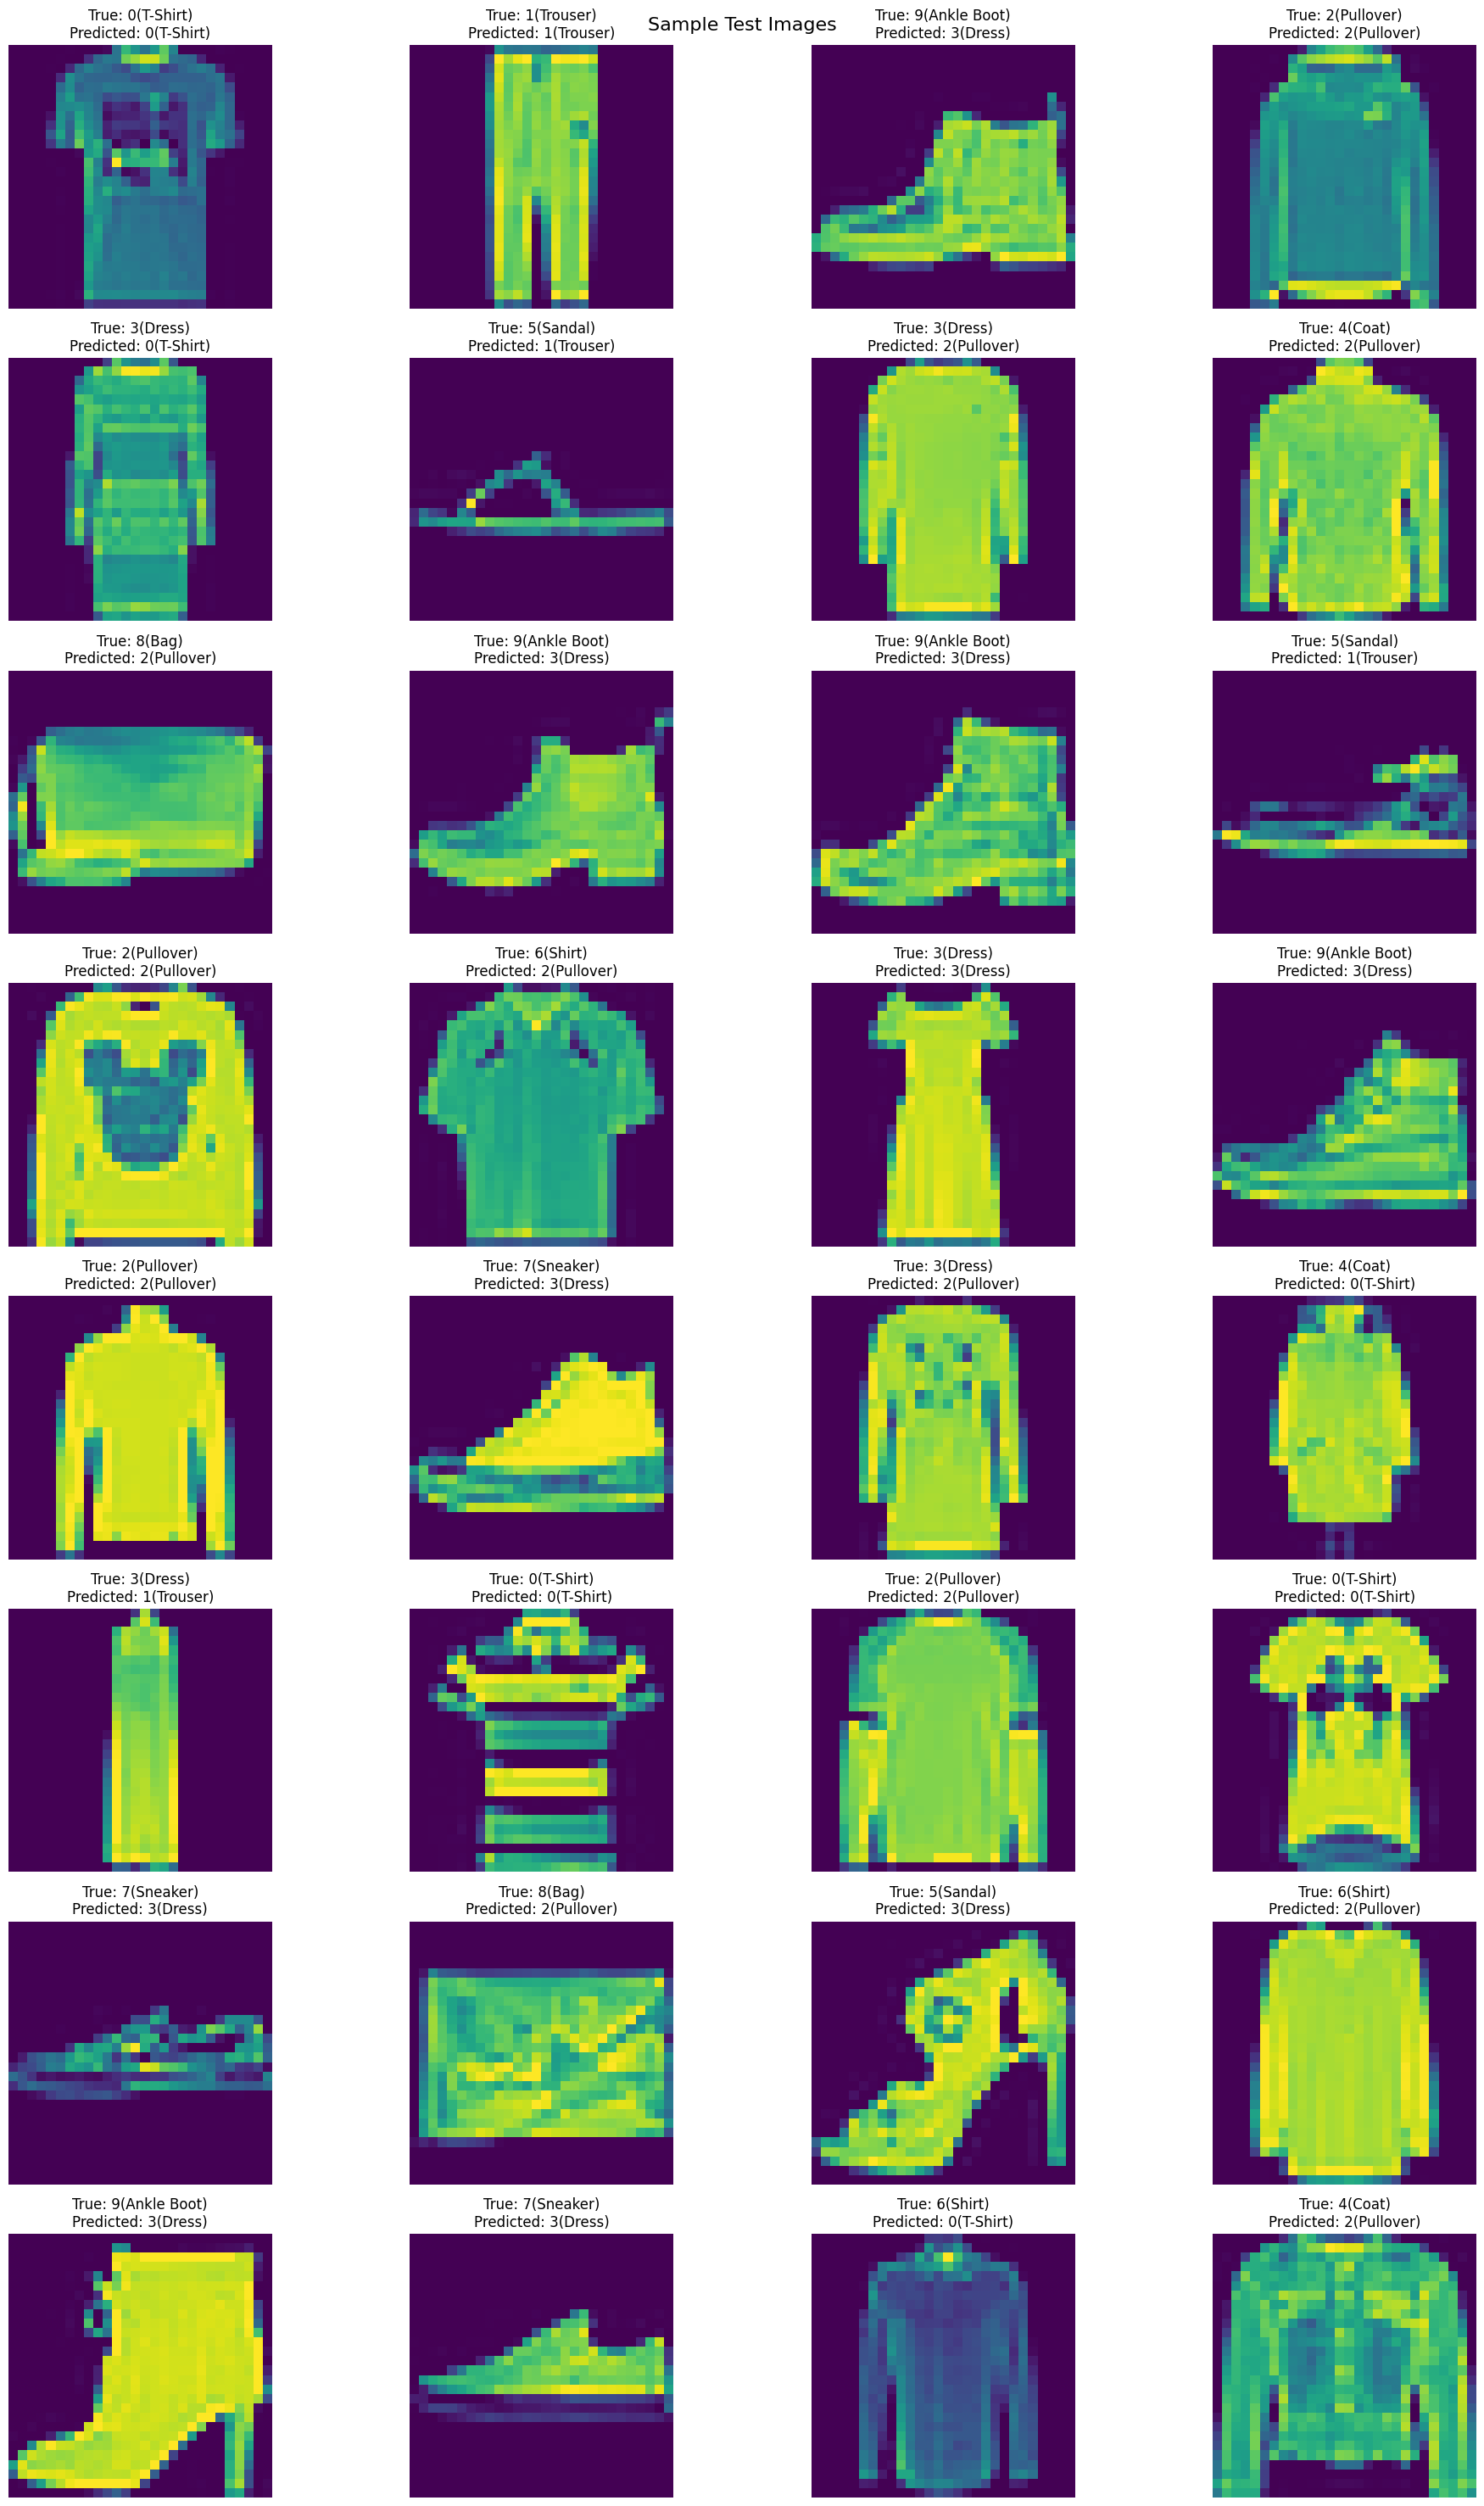

In [36]:
sample_images, sample_labels = next(iter(test_dataloader))

labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
    }

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 30))
fig.suptitle("Sample Test Images", fontsize=16)

with torch.no_grad():
  outputs = model_1(sample_images)
  _, predicted = torch.max(outputs.data, 1)

  for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_images[i].squeeze())
    ax.set_title(f"True: {sample_labels[i]}({labels_map[sample_labels[i].item()]})\nPredicted: {predicted[i].item()}({labels_map[predicted[i].item()]})")
    ax.axis('off')
plt.tight_layout()
plt.show()